## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, spacy, stop words and English language model
from string import punctuation
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer, LatentDirichletAllocation, CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Image, en_core_web_sm, scattertext, WordCloud, STOPWORDS, ImageColorGenerator, 
from PIL import Image
import en_core_web_sm
import scattertext as st
nlp = en_core_web_sm.load()
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#Classification
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import multiprocessing


In [2]:
congress_tweets = pd.read_csv("116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
#congress_tweets = congress_tweets.sample(...)
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.081010e+18,RepByrne,2019-01-03T21:23:00-05:00,Great news for Baldwin County! The economy of ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
1,1.080880e+18,RepByrne,2019-01-03T12:30:38-05:00,Outstanding news today from @Airbus! @JetBlue ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
2,1.080830e+18,RepByrne,2019-01-03T09:12:07-05:00,RT @senatemajldr Democrats will have to get se...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
3,1.080890e+18,RepByrne,2019-01-03T13:20:53-05:00,Here is a sign of things to come: As Democrats...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
4,1.080870e+18,RepByrne,2019-01-03T12:10:26-05:00,Let's understand what we're dealing with here:...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"


In [3]:
congress_tweets=congress_tweets.drop(['tweet_id', 'screen_name'],axis=1)

In [4]:
congress_tweets

,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,2019-01-03T21:23:00-05:00,Great news for Baldwin County! The economy of ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
1,2019-01-03T12:30:38-05:00,Outstanding news today from @Airbus! @JetBlue ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
2,2019-01-03T09:12:07-05:00,RT @senatemajldr Democrats will have to get se...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
3,2019-01-03T13:20:53-05:00,Here is a sign of things to come: As Democrats...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
4,2019-01-03T12:10:26-05:00,Let's understand what we're dealing with here:...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946786,2020-12-25T08:15:00-05:00,"From our family to yours, we wish you a very M...",Liz Cheney,Rep,3-Jan-17,7/28/1966,F,WY,0,Republican,"174,419","55,973","69,286","170,962"
946787,2020-12-25T09:04:53-05:00,Bobbi and I wish everyone a wonderful Christma...,John Barrasso,Sen,3-Jan-19,7/21/1952,M,WY,Senate,Republican,"174,419","55,973","69,286","170,962"
946788,2020-12-28T11:20:02-05:00,God bless the six brave law enforcement office...,Liz Cheney,Rep,3-Jan-17,7/28/1966,F,WY,0,Republican,"174,419","55,973","69,286","170,962"
946789,2021-01-01T08:15:00-05:00,Wishing a healthy and very happy New Year to e...,Liz Cheney,Rep,3-Jan-17,7/28/1966,F,WY,0,Republican,"174,419","55,973","69,286","170,962"


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [5]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith(('http', 'RT'))]
    
    #spacy_words2 = [token.text.lower() for token in doc]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [6]:
text = congress_tweets['text'][2]

In [7]:
tokens_reduced = rem_punc_stop(text)
tokens_reduced

['senatemajldr',
 'Democrats',
 'border',
 'security',
 'government',
 'funding',
 'agreement',
 'pass',
 'House',
 'earn',
 '60',
 'votes',
 'Senate',
 'receive',
 'presidential',
 'signature',
 'All',
 'things',
 'needed',
 'One',
 'partisan',
 'vote',
 'House',
 'wo',
 'nt',
 'solve']

In [8]:
numpy.random.seed(10)
ct_sub = congress_tweets.sample(n=3000)

In [9]:
ct_sub

,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
36257,2020-06-25T10:22:13-04:00,"Before adopting Olivia, we spent a great amoun...",David Schweikert,Rep,3-Jan-13,3/3/1962,M,AZ,6,Republican,"1,252,401","1,161,167","1,025,232","1,233,654"
548996,2019-01-07T09:33:39-05:00,Are we supposed to take Trump seriously or lit...,Sean Patrick Maloney,Rep,3-Jan-13,7/30/1966,M,NY,18,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"
652347,2020-10-30T16:24:14-04:00,Thank you to Lieutenant Mike Tarr and Fire Chi...,Steve Chabot,Rep,3-Jan-11,1/22/1953,M,OH,1,Republican,"2,841,005","2,394,164","2,827,709","2,661,437"
267614,2019-03-07T13:33:23-05:00,Made remarks to @AmFreeSyria sharing my concer...,Jim Risch,Sen,3-Jan-09,5/3/1943,M,ID,Senate,Republican,"409,055","189,765","212,787","420,911"
344386,2019-02-17T23:35:06-05:00,@jeroneanderson @MontcoLP @LelandShow @realDon...,Thomas Massie,Rep,13-Nov-12,1/13/1971,M,KY,4,Republican,"1,202,971","628,854","679,370","1,087,190"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289949,2019-12-20T09:38:54-05:00,That’s one reason why I’m proud to have secure...,Tammy Duckworth,Sen,3-Jan-17,3/12/1968,F,IL,Senate,Democrat,"2,146,015","3,090,729","3,019,512","2,135,216"
590720,2020-05-07T15:20:53-04:00,"We need more funds for #EIDL and, in meantime,...",Nydia Velázquez,Rep,3-Jan-13,3/28/1953,F,NY,7,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"
601127,2020-09-04T09:49:40-04:00,A strong US economic recovery is well underway...,Lee Zeldin,Rep,3-Jan-15,1/30/1980,M,NY,1,Republican,"2,819,533","4,556,118","4,485,741","2,490,431"
264039,2020-08-25T16:22:34-04:00,The Savannah Harbor Expansion Project is on tr...,David Perdue,Sen,3-Jan-15,12/10/1949,M,GA,Senate,Republican,"2,089,104","1,877,963","1,773,827","2,078,688"


In [10]:
ct_sub['tokens'] = ct_sub['text'].map(lambda x: rem_punc_stop(x))
ct_sub['tokens']

36257     [Before, adopting, Olivia, spent, great, time,...
548996    [Are, supposed, Trump, seriously, literally, s...
652347    [Thank, Lieutenant, Mike, Tarr, Fire, Chief, O...
267614    [Made, remarks, AmFreeSyria, sharing, concern,...
344386    [jeroneanderson, MontcoLP, LelandShow, realDon...
                                ...                        
289949    [That, reason, I, proud, secured, provisions, ...
590720    [We, need, funds, EIDL, meantime, SBAGov, queu...
601127    [A, strong, US, economic, recovery, underway, ...
264039    [The, Savannah, Harbor, Expansion, Project, tr...
720271    [RIHEALTH, GovRaimondo, All, customerfacing, b...
Name: tokens, Length: 3000, dtype: object

In [11]:
ct_sub['tokens_str'] = ct_sub['tokens'].map(lambda text: ' '.join(text))

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered <u>word frequencies,</u> <u>word clouds,</u> <u>word/character counts,</u> <u>scattertext,</u> and <u>topic modeling</u> as possible exploration tools. 

### EDA 1 - Word Cloud

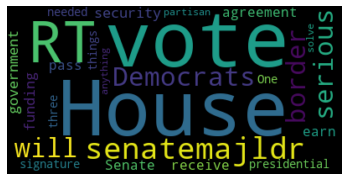

In [12]:
wordtext = ' '.join(ct_sub['tokens'].map(lambda wordtext: ' '.join(wordtext)))
wordcloud = WordCloud().generate(text)
ct_sub['wordcloud'] = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show() 

We noticed that RT appeared in the word cloud but RT refers to retweet and won't help us with analysis so we're going to adjust the rem_punc_stop function to remove the word from all tweets.

In [13]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    # Individually
    nlp.Defaults.stop_words |= {"RT", "QT","amp"} 
    
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

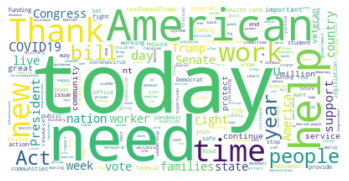

In [14]:
ct_sub['tokens'] = ct_sub['text'].map(lambda x: rem_punc_stop(x))
text = ' '.join(ct_sub['tokens'].map(lambda text: ' '.join(text)))

wordcloud = WordCloud(background_color = "white").generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### EDA 2 - Topic Modeling 

#### Part 1: 5 components

In [15]:
#create  tf-idf matrix
X = ct_sub['text']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)

tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense() 

In [16]:
#apply LDA model with hyperparameter n_components = 5
lda = LatentDirichletAllocation(n_components=5, max_iter=20, random_state=0)
lda = lda.fit(dense_matrix)

In [17]:
#print topics
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [18]:
#print top words
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 20)


Topic #0:


 
 rt today need   health president — people act help qt country new house americans time ” american

Topic #1:


 rt   today 
 qt people trump act work thank congress workers support need president new veterans time coronavirus

Topic #2:

 

 rt health help   today day covid19 work people president care security workers “ act ” join public

Topic #3:


 rt 
 trump president covid19 today time qt people health need bill   senate act — help – house

Topic #4:


 rt today   
 house qt american health act trump president bill country right work time covid19 vote public



In [19]:
#compare prevalence of each topic across documents

#get topic distribution array
topic_dist = lda.transform(tfidf_matrix)
topic_dist

array([[0.03053422, 0.03056252, 0.03046174, 0.87810282, 0.03033871],
       [0.8025805 , 0.04919465, 0.04928476, 0.04954057, 0.04939951],
       [0.04769495, 0.80808582, 0.04823585, 0.04798198, 0.0480014 ],
       ...,
       [0.03780659, 0.03784669, 0.84864528, 0.03771955, 0.03798189],
       [0.04398935, 0.82416625, 0.04384891, 0.04388408, 0.0441114 ],
       [0.03708054, 0.03717412, 0.03698556, 0.03801779, 0.85074198]])

In [20]:
#merge back with original df
topic_dist_df = pd.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(ct_sub.reset_index())
df_w_topics.head()

,0,1,2,3,4,index,datetime,text,name_wikipedia,position,...,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tokens_str,wordcloud
0,0.030534,0.030563,0.030462,0.878103,0.030339,36257,2020-06-25T10:22:13-04:00,"Before adopting Olivia, we spent a great amoun...",David Schweikert,Rep,...,AZ,6,Republican,"1,252,401","1,161,167","1,025,232","1,233,654","[Before, adopting, Olivia, spent, great, time,...",Before adopting Olivia spent great time learni...,<wordcloud.wordcloud.WordCloud object at 0x000...
1,0.802581,0.049195,0.049285,0.049541,0.049400,548996,2019-01-07T09:33:39-05:00,Are we supposed to take Trump seriously or lit...,Sean Patrick Maloney,Rep,...,NY,18,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[Are, supposed, Trump, seriously, literally, s...",Are supposed Trump seriously literally steel b...,<wordcloud.wordcloud.WordCloud object at 0x000...
2,0.047695,0.808086,0.048236,0.047982,0.048001,652347,2020-10-30T16:24:14-04:00,Thank you to Lieutenant Mike Tarr and Fire Chi...,Steve Chabot,Rep,...,OH,1,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[Thank, Lieutenant, Mike, Tarr, Fire, Chief, O...",Thank Lieutenant Mike Tarr Fire Chief Ott Hube...,<wordcloud.wordcloud.WordCloud object at 0x000...
3,0.034630,0.034251,0.034399,0.861849,0.034871,267614,2019-03-07T13:33:23-05:00,Made remarks to @AmFreeSyria sharing my concer...,Jim Risch,Sen,...,ID,Senate,Republican,"409,055","189,765","212,787","420,911","[Made, remarks, AmFreeSyria, sharing, concern,...",Made remarks AmFreeSyria sharing concern devas...,<wordcloud.wordcloud.WordCloud object at 0x000...
4,0.054129,0.054100,0.054219,0.054048,0.783504,344386,2019-02-17T23:35:06-05:00,@jeroneanderson @MontcoLP @LelandShow @realDon...,Thomas Massie,Rep,...,KY,4,Republican,"1,202,971","628,854","679,370","1,087,190","[jeroneanderson, MontcoLP, LelandShow, realDon...",jeroneanderson MontcoLP LelandShow realDonaldT...,<wordcloud.wordcloud.WordCloud object at 0x000...


In [21]:
ct_sub

,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tokens_str,wordcloud
36257,2020-06-25T10:22:13-04:00,"Before adopting Olivia, we spent a great amoun...",David Schweikert,Rep,3-Jan-13,3/3/1962,M,AZ,6,Republican,"1,252,401","1,161,167","1,025,232","1,233,654","[Before, adopting, Olivia, spent, great, time,...",Before adopting Olivia spent great time learni...,<wordcloud.wordcloud.WordCloud object at 0x000...
548996,2019-01-07T09:33:39-05:00,Are we supposed to take Trump seriously or lit...,Sean Patrick Maloney,Rep,3-Jan-13,7/30/1966,M,NY,18,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[Are, supposed, Trump, seriously, literally, s...",Are supposed Trump seriously literally steel b...,<wordcloud.wordcloud.WordCloud object at 0x000...
652347,2020-10-30T16:24:14-04:00,Thank you to Lieutenant Mike Tarr and Fire Chi...,Steve Chabot,Rep,3-Jan-11,1/22/1953,M,OH,1,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[Thank, Lieutenant, Mike, Tarr, Fire, Chief, O...",Thank Lieutenant Mike Tarr Fire Chief Ott Hube...,<wordcloud.wordcloud.WordCloud object at 0x000...
267614,2019-03-07T13:33:23-05:00,Made remarks to @AmFreeSyria sharing my concer...,Jim Risch,Sen,3-Jan-09,5/3/1943,M,ID,Senate,Republican,"409,055","189,765","212,787","420,911","[Made, remarks, AmFreeSyria, sharing, concern,...",Made remarks AmFreeSyria sharing concern devas...,<wordcloud.wordcloud.WordCloud object at 0x000...
344386,2019-02-17T23:35:06-05:00,@jeroneanderson @MontcoLP @LelandShow @realDon...,Thomas Massie,Rep,13-Nov-12,1/13/1971,M,KY,4,Republican,"1,202,971","628,854","679,370","1,087,190","[jeroneanderson, MontcoLP, LelandShow, realDon...",jeroneanderson MontcoLP LelandShow realDonaldT...,<wordcloud.wordcloud.WordCloud object at 0x000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289949,2019-12-20T09:38:54-05:00,That’s one reason why I’m proud to have secure...,Tammy Duckworth,Sen,3-Jan-17,3/12/1968,F,IL,Senate,Democrat,"2,146,015","3,090,729","3,019,512","2,135,216","[That, reason, I, proud, secured, provisions, ...",That reason I proud secured provisions NDAA he...,<wordcloud.wordcloud.WordCloud object at 0x000...
590720,2020-05-07T15:20:53-04:00,"We need more funds for #EIDL and, in meantime,...",Nydia Velázquez,Rep,3-Jan-13,3/28/1953,F,NY,7,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[We, need, funds, EIDL, meantime, SBAGov, queu...",We need funds EIDL meantime SBAGov queue loan ...,<wordcloud.wordcloud.WordCloud object at 0x000...
601127,2020-09-04T09:49:40-04:00,A strong US economic recovery is well underway...,Lee Zeldin,Rep,3-Jan-15,1/30/1980,M,NY,1,Republican,"2,819,533","4,556,118","4,485,741","2,490,431","[A, strong, US, economic, recovery, underway, ...",A strong US economic recovery underway faster ...,<wordcloud.wordcloud.WordCloud object at 0x000...
264039,2020-08-25T16:22:34-04:00,The Savannah Harbor Expansion Project is on tr...,David Perdue,Sen,3-Jan-15,12/10/1949,M,GA,Senate,Republican,"2,089,104","1,877,963","1,773,827","2,078,688","[The, Savannah, Harbor, Expansion, Project, tr...",The Savannah Harbor Expansion Project track co...,<wordcloud.wordcloud.WordCloud object at 0x000...


In [22]:
#check average weight of each topic across party using group by
grouped = df_w_topics.groupby('party')
for i in range(0, 5):
    print(grouped[i].mean().sort_values(ascending=False))

party
Independent    0.220841
Democrat       0.199818
Republican     0.198151
Name: 0, dtype: float64
party
Republican     0.183119
Democrat       0.173824
Independent    0.159807
Name: 1, dtype: float64
party
Republican     0.190383
Democrat       0.179141
Independent    0.163164
Name: 2, dtype: float64
party
Democrat       0.236095
Independent    0.224854
Republican     0.196998
Name: 3, dtype: float64
party
Republican     0.231350
Independent    0.231335
Democrat       0.211121
Name: 4, dtype: float64


In [23]:
#check average weight of each topic across position using group by
grouped = df_w_topics.groupby('position')
for i in range(0, 5):
    print(grouped[i].mean().sort_values(ascending=False))

position
Rep    0.199410
Sen    0.199024
Name: 0, dtype: float64
position
Rep    0.180365
Sen    0.166334
Name: 1, dtype: float64
position
Rep    0.184974
Sen    0.176827
Name: 2, dtype: float64
position
Sen    0.224648
Rep    0.221452
Name: 3, dtype: float64
position
Sen    0.233167
Rep    0.213799
Name: 4, dtype: float64


<b> What do we see so far? </b>
With n_components = 5, we don't really see much separation for either party or position.  Going to retrain LDA with more topics, n_topics = 10. 

### EDA 2 - Topic Modeling 

#### Part 2: 10 components

In [24]:
#apply LDA model with hyperparameter n_components = 10
lda_10 = LatentDirichletAllocation(n_components=10, max_iter=20, random_state=0)
lda_10 = lda_10.fit(dense_matrix)

In [25]:
#print topics
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [26]:
#print top words
tf_feature_names = tf.get_feature_names()
print_top_words(lda_10, tf_feature_names, 20)


Topic #0:


 rt today 
 president   trump proud act senate qt help “ protect ” time 
 
 health people women

Topic #1:


   rt 
 people today trump workers act qt nt need community women federal work working care day country

Topic #2:

 

 rt today   help join covid19 qt great work need people important security 🚨 americans small businesses federal

Topic #3:


 
 rt president thank house people today covid19 support qt health trump congress senate time act bill need new

Topic #4:


 rt 
 today american   house country qt president work health veterans time trump right act realdonaldtrump care americans

Topic #5:


 rt need 
 today new america act president help “ 
 
 people congress ” bill time protect women qt

Topic #6:


 rt   
 qt today trump senate great president support people american need act families house help health covid19

Topic #7:


 rt 
   today trump people congress president covid19 know house qt help bill care families health realdonaldtrump act

Topic #8:


 h

In [27]:
#compare prevalence of each topic across documents

#get topic distribution array
topic_dist = lda_10.transform(tfidf_matrix)
topic_dist

array([[0.01497814, 0.01497418, 0.01497761, ..., 0.01497932, 0.01497611,
        0.86519816],
       [0.02432406, 0.02432291, 0.02432311, ..., 0.78108878, 0.02432359,
        0.02432425],
       [0.02362255, 0.02362275, 0.02362252, ..., 0.023624  , 0.02362614,
        0.02362304],
       ...,
       [0.01859277, 0.01859405, 0.01859448, ..., 0.83265399, 0.01859316,
        0.0185938 ],
       [0.02171958, 0.02171854, 0.02172242, ..., 0.0217219 , 0.02172346,
        0.0217185 ],
       [0.01820234, 0.01820103, 0.01820036, ..., 0.01820571, 0.01820067,
        0.0182026 ]])

In [28]:
#merge back with original df
topic_dist_df = pd.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(ct_sub.reset_index())
df_w_topics.head()

,0,1,2,3,4,5,6,7,8,9,...,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tokens_str,wordcloud
0,0.014978,0.014974,0.014978,0.014981,0.014978,0.014980,0.014978,0.014979,0.014976,0.865198,...,AZ,6,Republican,"1,252,401","1,161,167","1,025,232","1,233,654","[Before, adopting, Olivia, spent, great, time,...",Before adopting Olivia spent great time learni...,<wordcloud.wordcloud.WordCloud object at 0x000...
1,0.024324,0.024323,0.024323,0.024323,0.024324,0.024323,0.024324,0.781089,0.024324,0.024324,...,NY,18,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[Are, supposed, Trump, seriously, literally, s...",Are supposed Trump seriously literally steel b...,<wordcloud.wordcloud.WordCloud object at 0x000...
2,0.023623,0.023623,0.023623,0.023625,0.023623,0.787389,0.023622,0.023624,0.023626,0.023623,...,OH,1,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[Thank, Lieutenant, Mike, Tarr, Fire, Chief, O...",Thank Lieutenant Mike Tarr Fire Chief Ott Hube...,<wordcloud.wordcloud.WordCloud object at 0x000...
3,0.016922,0.016924,0.016926,0.847686,0.016921,0.016922,0.016927,0.016927,0.016923,0.016921,...,ID,Senate,Republican,"409,055","189,765","212,787","420,911","[Made, remarks, AmFreeSyria, sharing, concern,...",Made remarks AmFreeSyria sharing concern devas...,<wordcloud.wordcloud.WordCloud object at 0x000...
4,0.026859,0.026859,0.026859,0.026859,0.026860,0.026858,0.026860,0.026860,0.026859,0.758267,...,KY,4,Republican,"1,202,971","628,854","679,370","1,087,190","[jeroneanderson, MontcoLP, LelandShow, realDon...",jeroneanderson MontcoLP LelandShow realDonaldT...,<wordcloud.wordcloud.WordCloud object at 0x000...


In [29]:
#check average weight of each topic across party using group by
grouped = df_w_topics.groupby('party')
for i in range(0, 10):
    print(grouped[i].mean().sort_values(ascending=False))

party
Independent    0.141269
Democrat       0.107658
Republican     0.087905
Name: 0, dtype: float64
party
Democrat       0.103171
Republican     0.089714
Independent    0.018152
Name: 1, dtype: float64
party
Republican     0.100952
Democrat       0.086764
Independent    0.018151
Name: 2, dtype: float64
party
Democrat       0.104404
Republican     0.098874
Independent    0.079247
Name: 3, dtype: float64
party
Independent    0.207615
Democrat       0.119358
Republican     0.115598
Name: 4, dtype: float64
party
Democrat       0.090952
Republican     0.088646
Independent    0.018150
Name: 5, dtype: float64
party
Independent    0.148877
Republican     0.106337
Democrat       0.093995
Name: 6, dtype: float64
party
Republican     0.096686
Democrat       0.090265
Independent    0.018151
Name: 7, dtype: float64
party
Independent    0.140060
Democrat       0.104938
Republican     0.101777
Name: 8, dtype: float64
party
Independent    0.210328
Republican     0.113511
Democrat       0.098494
Name

In [30]:
#check average weight of each topic across position using group by
grouped = df_w_topics.groupby('position')
for i in range(0, 10):
    print(grouped[i].mean().sort_values(ascending=False))

position
Rep    0.101453
Sen    0.098735
Name: 0, dtype: float64
position
Rep    0.099301
Sen    0.093953
Name: 1, dtype: float64
position
Rep    0.091863
Sen    0.090279
Name: 2, dtype: float64
position
Sen    0.107702
Rep    0.100680
Name: 3, dtype: float64
position
Sen    0.123790
Rep    0.116747
Name: 4, dtype: float64
position
Sen    0.099638
Rep    0.086788
Name: 5, dtype: float64
position
Rep    0.101313
Sen    0.089826
Name: 6, dtype: float64
position
Rep    0.095784
Sen    0.080706
Name: 7, dtype: float64
position
Sen    0.108011
Rep    0.102724
Name: 8, dtype: float64
position
Sen    0.107361
Rep    0.103348
Name: 9, dtype: float64


<b>What do we see?</b>
Still don't see much separation for either party or position. While the number of topics produced are sensitive to our choice of n, it doesn't seem like choosing more topics did any better in separating out topics by Congressional party or position. Feels like all Congressional members, irrespective of party and position seem to be having discussions around similar topics.  The ways they discuss these topics may differ, and it might be that sentiment analysis will do a better job picking up these difference of opinions. 

### EDA 3 - Word Count

In [31]:
ct_sub['word_count'] = ct_sub['text'].apply(lambda x: len(str(x).split()))

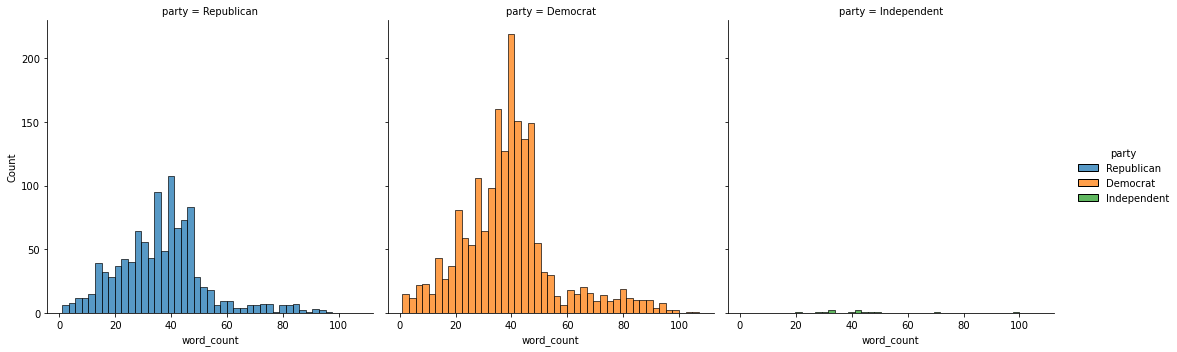

In [32]:
#for party
sns.displot(ct_sub, x="word_count", hue = "party", col = "party")
plt.show()

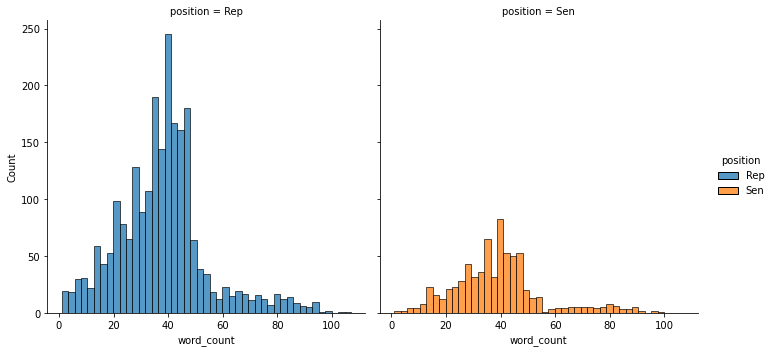

In [33]:
#for position
sns.displot(ct_sub, x="word_count", hue = "position", col = "position")
plt.show()

<b>What do we see?</b>
Democrats and Representatives have higher word count relative to their comparative counterparts (Republicans, and Senators, respectively). This might influence the results we see in the sentiment analysis and beyond.

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [34]:
# Sen. Nydia Velázquez (D) vs. Sen. Liz Cheney (R)

velázquez_text = congress_tweets[congress_tweets['name_wikipedia']=='Nydia Velázquez']['text']
velázquez_text

cheney_text = congress_tweets[congress_tweets['name_wikipedia']=='Liz Cheney']['text']
cheney_text

944272    Rep. Liz Cheney: "What's Immoral Is Not To Sec...
944273    RT @ThisWeekABC Rep. Liz Cheney says Speaker o...
944274    @hellafree19 @RedBankIrish Thanks very much. W...
944275    ICYMI: I joined @ThisWeekABC to discuss the De...
944278    I was honored to be at @Mark_Gordon_WY inaugur...
                                ...                        
946783    It’s been nearly two weeks since the American ...
946784    Today's announcement on the Record of Decision...
946786    From our family to yours, we wish you a very M...
946788    God bless the six brave law enforcement office...
946789    Wishing a healthy and very happy New Year to e...
Name: text, Length: 640, dtype: object

#### Sentiment

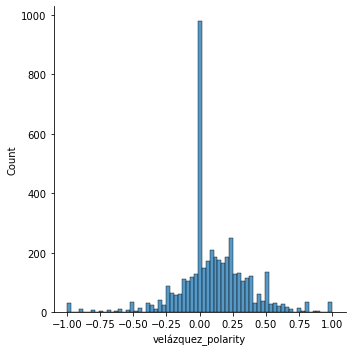

In [35]:
congress_tweets['velázquez_polarity']= velázquez_text.map(lambda text: TextBlob(text).sentiment.polarity)
sns.displot(congress_tweets, x='velázquez_polarity')
plt.show()

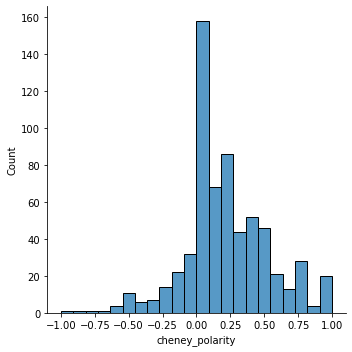

In [36]:
congress_tweets['cheney_polarity']= cheney_text.map(lambda text: TextBlob(text).sentiment.polarity)
sns.displot(congress_tweets, x='cheney_polarity')
plt.show()

<b>What do we see?</b>
According to the plots, both Senators' tweets are mostly nuetral. This matches what I'd assume, given that politicians tend to stay away from polarizing statements.

#### Subjectivity

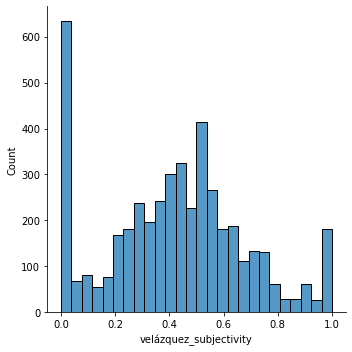

In [37]:
congress_tweets['velázquez_subjectivity'] = velázquez_text.map(lambda text: TextBlob(text).sentiment.subjectivity)
sns.displot(congress_tweets, x="velázquez_subjectivity")
plt.show()

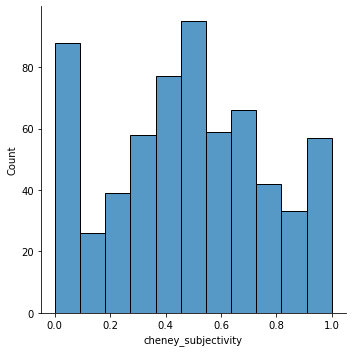

In [38]:
congress_tweets['cheney_subjectivity'] = cheney_text.map(lambda text: TextBlob(text).sentiment.subjectivity)
sns.displot(congress_tweets, x="cheney_subjectivity")
plt.show()

<b>What do we see?</b>
According to the plots, Senator Velázquez's tweets tend to be more objective. A significant portion of Senator Cheney's tweet are also objective, however Senator Cheney seems to have a mean closer to ~0.5. This may suggest that Democratic senators are more objective, however it may also be due to the much smaller sample from Senator Cheney.

#### Sentiment vs. Subjectivity

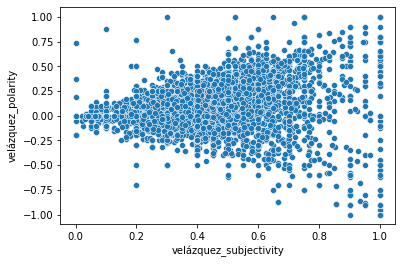

In [39]:
sns.scatterplot(data = congress_tweets, x = 'velázquez_subjectivity', y = 'velázquez_polarity')
plt.show()

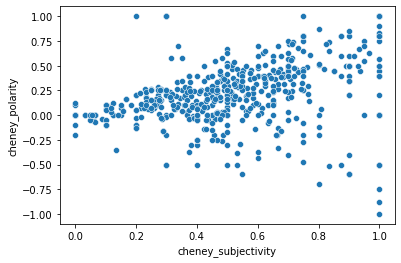

In [40]:
sns.scatterplot(data = congress_tweets, x = 'cheney_subjectivity', y = 'cheney_polarity')
plt.show()

<b>What do we see?</b>
According to the plots, both Senators' tweets become more polarizing as they become more subjective. In the case of Senator Cheney, however, this occurs in a much more positive direction than Senator Velázquez. This, again, may be due to the smaller sample size from Senator Cheney.

#### Democrats vs. Republicans

In [41]:
ct_sub['polarity']= ct_sub['tokens_str'].map(lambda text: TextBlob(text).sentiment.polarity)
ct_sub['subjectivity']= ct_sub['tokens_str'].map(lambda text: TextBlob(text).sentiment.subjectivity)

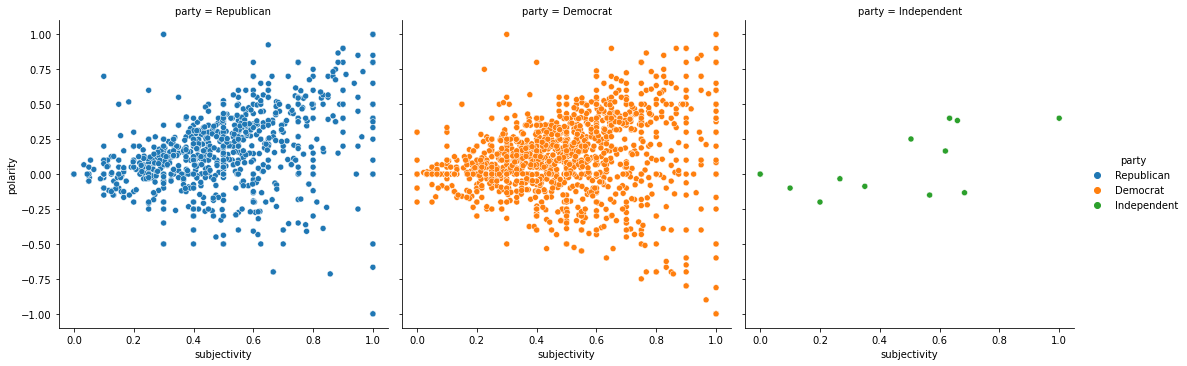

In [42]:
sns.relplot(
    data=ct_sub, x="subjectivity", y="polarity",
    col="party", hue = "party", kind="scatter"
)
plt.show()

<b>What do we see?</b>
These plots reveal a similar patter to the one we just saw between Senators Velázquez and Cheney. It seems that both parties' tweets become more positive as they get more subjective - although the relationship seems to be stronger for Republicans. This suggest what saw earlier was not due soley Senator Cheney's smaller sample size.

#### Senators vs. Representatives

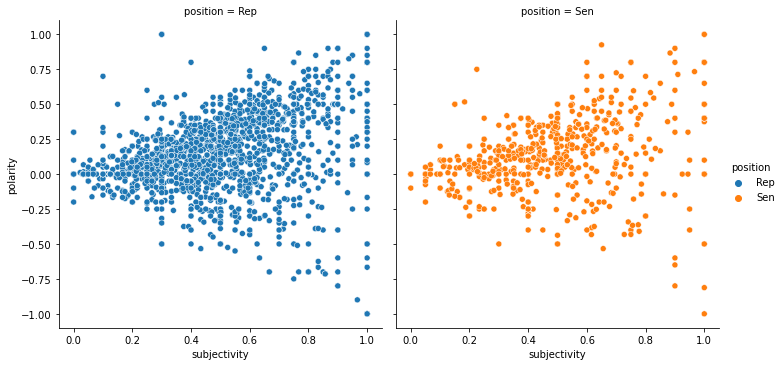

In [43]:
sns.relplot(
    data=ct_sub, x="subjectivity", y="polarity",
    col="position", hue = "position", kind="scatter"
)
plt.show()

<b>What do we see?</b>
Again, we see this same pattern. As tweets become mroe subjective, they also become more positive. The slight differences we see here are likely due to the composition of either chamber. For the 116th Congress, the Senate was majority Republican and the House was majority Democrat.

##### Does this look like what you would have thought? 

The more subjective tweets become, the more positive they are, but slightly more for Republicans. This didn’t make sense at face value, because we would have thought more subjectivity may have meant more negative sentiment, particularly for Republicans during the political climate of these tweets.  Upon further reflection, we thought that this slight difference might be due to the fact that there were more counter tweets from Democrats against Trump, who was quite active and divisive on twitter.  These increased counter tweets might have resulted in the more negative sentiment relative to the Republicans

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

In [44]:
ct_sub.columns

Index(['datetime', 'text', 'name_wikipedia', 'position',
       'joined_congress_date', 'birthday', 'gender', 'state',
       'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'tokens', 'tokens_str', 'wordcloud',
       'word_count', 'polarity', 'subjectivity'],
      dtype='object')

### Engineered Text Features

In [45]:
# Engineered Features, including wordcloud, word count, polarity and subjectivity
engineered_features = ct_sub[['word_count','polarity', 'subjectivity']].reset_index(drop = True)

In [46]:
engineered_features

,word_count,polarity,subjectivity
0,72,0.283333,0.491667
1,18,-0.333333,0.666667
2,24,0.500000,0.500000
3,43,-0.437500,0.500000
4,12,0.000000,0.000000
...,...,...,...
2995,25,0.100000,0.950000
2996,56,0.003333,0.441111
2997,34,0.133333,0.333333
2998,25,0.400000,0.775000


### Bag-of-words or Tf-idf

In [47]:
# Frequency Based featurization

# tfidf
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names())

### Word Embedding

In [48]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary = True) 

FileNotFoundError: [Errno 2] No such file or directory: 'GoogleNews-vectors-negative300.bin.gz'

In [ ]:
import numpy as np
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.wv.vocab]
    return np.mean(model.wv._getitem_(doc), axis=0)

In [ ]:
# embedding based featurization
model = gensim.models.Word2Vec(ct_sub['tokens'], size = 100, window = 5, \
                              min_count = 5, sg = 0, alpha = 0.025, iter = 5, batch_words = 10000)

In [ ]:
model.wv.vocab

In [ ]:
doc = [word for word in ct_sub.reset_index()['tokens'][0] if word in model.wv.vocab]
len(doc)

In [ ]:
doc[0:5]

In [ ]:
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.wv.vocab]
    return numpy.mean(word2vec_model.wv.__getitem__(doc), axis=0)

In [ ]:
# Initialize an array for the size of the corpus
empty_list_embeddings_means = []
for puppy in ct_sub['tokens_str']: # append the vector for each document
    empty_list_embeddings_means.append(document_vector(model, puppy))
    
doc_average_embeddings = numpy.array(empty_list_embeddings_means) # list to array 

In [ ]:
doc_average_embeddings

In [ ]:
dae_df = pd.DataFrame(doc_average_embeddings)

In [ ]:
dae_df

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [49]:
ct_sub

,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tokens_str,wordcloud,word_count,polarity,subjectivity
36257,2020-06-25T10:22:13-04:00,"Before adopting Olivia, we spent a great amoun...",David Schweikert,Rep,3-Jan-13,3/3/1962,M,AZ,6,Republican,"1,252,401","1,161,167","1,025,232","1,233,654","[Before, adopting, Olivia, spent, great, time,...",Before adopting Olivia spent great time learni...,<wordcloud.wordcloud.WordCloud object at 0x000...,72,0.283333,0.491667
548996,2019-01-07T09:33:39-05:00,Are we supposed to take Trump seriously or lit...,Sean Patrick Maloney,Rep,3-Jan-13,7/30/1966,M,NY,18,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[Are, supposed, Trump, seriously, literally, s...",Are supposed Trump seriously literally steel b...,<wordcloud.wordcloud.WordCloud object at 0x000...,18,-0.333333,0.666667
652347,2020-10-30T16:24:14-04:00,Thank you to Lieutenant Mike Tarr and Fire Chi...,Steve Chabot,Rep,3-Jan-11,1/22/1953,M,OH,1,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[Thank, Lieutenant, Mike, Tarr, Fire, Chief, O...",Thank Lieutenant Mike Tarr Fire Chief Ott Hube...,<wordcloud.wordcloud.WordCloud object at 0x000...,24,0.500000,0.500000
267614,2019-03-07T13:33:23-05:00,Made remarks to @AmFreeSyria sharing my concer...,Jim Risch,Sen,3-Jan-09,5/3/1943,M,ID,Senate,Republican,"409,055","189,765","212,787","420,911","[Made, remarks, AmFreeSyria, sharing, concern,...",Made remarks AmFreeSyria sharing concern devas...,<wordcloud.wordcloud.WordCloud object at 0x000...,43,-0.437500,0.500000
344386,2019-02-17T23:35:06-05:00,@jeroneanderson @MontcoLP @LelandShow @realDon...,Thomas Massie,Rep,13-Nov-12,1/13/1971,M,KY,4,Republican,"1,202,971","628,854","679,370","1,087,190","[jeroneanderson, MontcoLP, LelandShow, realDon...",jeroneanderson MontcoLP LelandShow realDonaldT...,<wordcloud.wordcloud.WordCloud object at 0x000...,12,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289949,2019-12-20T09:38:54-05:00,That’s one reason why I’m proud to have secure...,Tammy Duckworth,Sen,3-Jan-17,3/12/1968,F,IL,Senate,Democrat,"2,146,015","3,090,729","3,019,512","2,135,216","[That, reason, I, proud, secured, provisions, ...",That reason I proud secured provisions NDAA he...,<wordcloud.wordcloud.WordCloud object at 0x000...,25,0.100000,0.950000
590720,2020-05-07T15:20:53-04:00,"We need more funds for #EIDL and, in meantime,...",Nydia Velázquez,Rep,3-Jan-13,3/28/1953,F,NY,7,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[We, need, funds, EIDL, meantime, SBAGov, queu...",We need funds EIDL meantime SBAGov queue loan ...,<wordcloud.wordcloud.WordCloud object at 0x000...,56,0.003333,0.441111
601127,2020-09-04T09:49:40-04:00,A strong US economic recovery is well underway...,Lee Zeldin,Rep,3-Jan-15,1/30/1980,M,NY,1,Republican,"2,819,533","4,556,118","4,485,741","2,490,431","[A, strong, US, economic, recovery, underway, ...",A strong US economic recovery underway faster ...,<wordcloud.wordcloud.WordCloud object at 0x000...,34,0.133333,0.333333
264039,2020-08-25T16:22:34-04:00,The Savannah Harbor Expansion Project is on tr...,David Perdue,Sen,3-Jan-15,12/10/1949,M,GA,Senate,Republican,"2,089,104","1,877,963","1,773,827","2,078,688","[The, Savannah, Harbor, Expansion, Project, tr...",The Savannah Harbor Expansion Project track co...,<wordcloud.wordcloud.WordCloud object at 0x000...,25,0.400000,0.775000


Creat a column with only Democrats and Republicans

In [50]:
ct_sub['DR'] = ct_sub['party']. apply(lambda x : 0 if x =='Democrat' and x!='Independent' else 1)

In [51]:
ct_sub

,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,...,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tokens_str,wordcloud,word_count,polarity,subjectivity,DR
36257,2020-06-25T10:22:13-04:00,"Before adopting Olivia, we spent a great amoun...",David Schweikert,Rep,3-Jan-13,3/3/1962,M,AZ,6,Republican,...,"1,161,167","1,025,232","1,233,654","[Before, adopting, Olivia, spent, great, time,...",Before adopting Olivia spent great time learni...,<wordcloud.wordcloud.WordCloud object at 0x000...,72,0.283333,0.491667,1
548996,2019-01-07T09:33:39-05:00,Are we supposed to take Trump seriously or lit...,Sean Patrick Maloney,Rep,3-Jan-13,7/30/1966,M,NY,18,Democrat,...,"4,556,118","4,485,741","2,490,431","[Are, supposed, Trump, seriously, literally, s...",Are supposed Trump seriously literally steel b...,<wordcloud.wordcloud.WordCloud object at 0x000...,18,-0.333333,0.666667,0
652347,2020-10-30T16:24:14-04:00,Thank you to Lieutenant Mike Tarr and Fire Chi...,Steve Chabot,Rep,3-Jan-11,1/22/1953,M,OH,1,Republican,...,"2,394,164","2,827,709","2,661,437","[Thank, Lieutenant, Mike, Tarr, Fire, Chief, O...",Thank Lieutenant Mike Tarr Fire Chief Ott Hube...,<wordcloud.wordcloud.WordCloud object at 0x000...,24,0.500000,0.500000,1
267614,2019-03-07T13:33:23-05:00,Made remarks to @AmFreeSyria sharing my concer...,Jim Risch,Sen,3-Jan-09,5/3/1943,M,ID,Senate,Republican,...,"189,765","212,787","420,911","[Made, remarks, AmFreeSyria, sharing, concern,...",Made remarks AmFreeSyria sharing concern devas...,<wordcloud.wordcloud.WordCloud object at 0x000...,43,-0.437500,0.500000,1
344386,2019-02-17T23:35:06-05:00,@jeroneanderson @MontcoLP @LelandShow @realDon...,Thomas Massie,Rep,13-Nov-12,1/13/1971,M,KY,4,Republican,...,"628,854","679,370","1,087,190","[jeroneanderson, MontcoLP, LelandShow, realDon...",jeroneanderson MontcoLP LelandShow realDonaldT...,<wordcloud.wordcloud.WordCloud object at 0x000...,12,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289949,2019-12-20T09:38:54-05:00,That’s one reason why I’m proud to have secure...,Tammy Duckworth,Sen,3-Jan-17,3/12/1968,F,IL,Senate,Democrat,...,"3,090,729","3,019,512","2,135,216","[That, reason, I, proud, secured, provisions, ...",That reason I proud secured provisions NDAA he...,<wordcloud.wordcloud.WordCloud object at 0x000...,25,0.100000,0.950000,0
590720,2020-05-07T15:20:53-04:00,"We need more funds for #EIDL and, in meantime,...",Nydia Velázquez,Rep,3-Jan-13,3/28/1953,F,NY,7,Democrat,...,"4,556,118","4,485,741","2,490,431","[We, need, funds, EIDL, meantime, SBAGov, queu...",We need funds EIDL meantime SBAGov queue loan ...,<wordcloud.wordcloud.WordCloud object at 0x000...,56,0.003333,0.441111,0
601127,2020-09-04T09:49:40-04:00,A strong US economic recovery is well underway...,Lee Zeldin,Rep,3-Jan-15,1/30/1980,M,NY,1,Republican,...,"4,556,118","4,485,741","2,490,431","[A, strong, US, economic, recovery, underway, ...",A strong US economic recovery underway faster ...,<wordcloud.wordcloud.WordCloud object at 0x000...,34,0.133333,0.333333,1
264039,2020-08-25T16:22:34-04:00,The Savannah Harbor Expansion Project is on tr...,David Perdue,Sen,3-Jan-15,12/10/1949,M,GA,Senate,Republican,...,"1,877,963","1,773,827","2,078,688","[The, Savannah, Harbor, Expansion, Project, tr...",The Savannah Harbor Expansion Project track co...,<wordcloud.wordcloud.WordCloud object at 0x000...,25,0.400000,0.775000,1


Join dataframes together

In [52]:
dataframes = [engineered_features,
                    topic_dist_df, 
                    tfidf_df]

featurization_technique = ['Engineered Text Features', 
                            'Topic Model',
                             'Tf-idf Features']


In [53]:
# binarize label
lb_style = LabelBinarizer()
y = ct_sub['party_binary'] = lb_style.fit_transform(ct_sub['DR'])


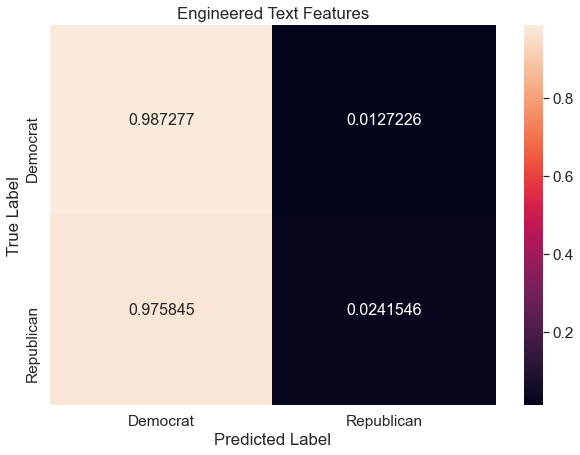

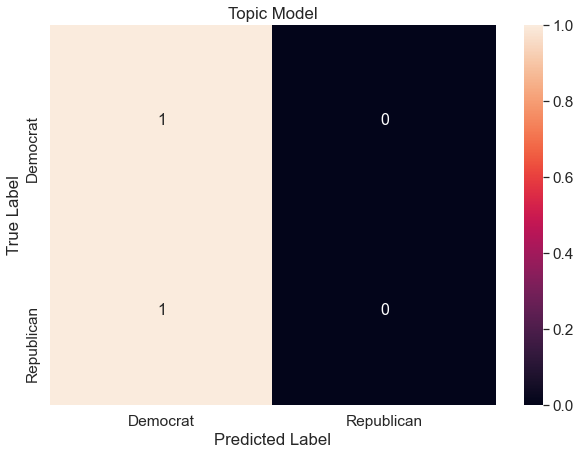

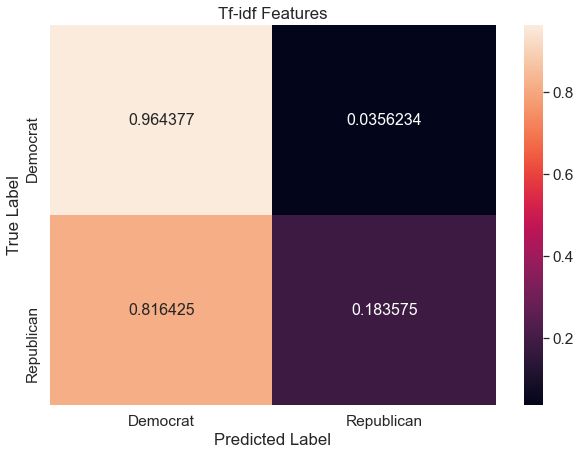

In [54]:
for dataframe, featurization in zip(dataframes, featurization_technique):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
    df_cm.index = ["Democrat", "Republican"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

<b>What do we see?</b>
It appears that the model does a better job of predicting Democrat than it does predicting Republican. 

In [55]:
y2 = ct_sub['position_binary'] = lb_style.fit_transform(ct_sub['position'])

In [56]:
ct_sub

,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,...,romney_2012_state_share,tokens,tokens_str,wordcloud,word_count,polarity,subjectivity,DR,party_binary,position_binary
36257,2020-06-25T10:22:13-04:00,"Before adopting Olivia, we spent a great amoun...",David Schweikert,Rep,3-Jan-13,3/3/1962,M,AZ,6,Republican,...,"1,233,654","[Before, adopting, Olivia, spent, great, time,...",Before adopting Olivia spent great time learni...,<wordcloud.wordcloud.WordCloud object at 0x000...,72,0.283333,0.491667,1,1,0
548996,2019-01-07T09:33:39-05:00,Are we supposed to take Trump seriously or lit...,Sean Patrick Maloney,Rep,3-Jan-13,7/30/1966,M,NY,18,Democrat,...,"2,490,431","[Are, supposed, Trump, seriously, literally, s...",Are supposed Trump seriously literally steel b...,<wordcloud.wordcloud.WordCloud object at 0x000...,18,-0.333333,0.666667,0,0,0
652347,2020-10-30T16:24:14-04:00,Thank you to Lieutenant Mike Tarr and Fire Chi...,Steve Chabot,Rep,3-Jan-11,1/22/1953,M,OH,1,Republican,...,"2,661,437","[Thank, Lieutenant, Mike, Tarr, Fire, Chief, O...",Thank Lieutenant Mike Tarr Fire Chief Ott Hube...,<wordcloud.wordcloud.WordCloud object at 0x000...,24,0.500000,0.500000,1,1,0
267614,2019-03-07T13:33:23-05:00,Made remarks to @AmFreeSyria sharing my concer...,Jim Risch,Sen,3-Jan-09,5/3/1943,M,ID,Senate,Republican,...,"420,911","[Made, remarks, AmFreeSyria, sharing, concern,...",Made remarks AmFreeSyria sharing concern devas...,<wordcloud.wordcloud.WordCloud object at 0x000...,43,-0.437500,0.500000,1,1,1
344386,2019-02-17T23:35:06-05:00,@jeroneanderson @MontcoLP @LelandShow @realDon...,Thomas Massie,Rep,13-Nov-12,1/13/1971,M,KY,4,Republican,...,"1,087,190","[jeroneanderson, MontcoLP, LelandShow, realDon...",jeroneanderson MontcoLP LelandShow realDonaldT...,<wordcloud.wordcloud.WordCloud object at 0x000...,12,0.000000,0.000000,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289949,2019-12-20T09:38:54-05:00,That’s one reason why I’m proud to have secure...,Tammy Duckworth,Sen,3-Jan-17,3/12/1968,F,IL,Senate,Democrat,...,"2,135,216","[That, reason, I, proud, secured, provisions, ...",That reason I proud secured provisions NDAA he...,<wordcloud.wordcloud.WordCloud object at 0x000...,25,0.100000,0.950000,0,0,1
590720,2020-05-07T15:20:53-04:00,"We need more funds for #EIDL and, in meantime,...",Nydia Velázquez,Rep,3-Jan-13,3/28/1953,F,NY,7,Democrat,...,"2,490,431","[We, need, funds, EIDL, meantime, SBAGov, queu...",We need funds EIDL meantime SBAGov queue loan ...,<wordcloud.wordcloud.WordCloud object at 0x000...,56,0.003333,0.441111,0,0,0
601127,2020-09-04T09:49:40-04:00,A strong US economic recovery is well underway...,Lee Zeldin,Rep,3-Jan-15,1/30/1980,M,NY,1,Republican,...,"2,490,431","[A, strong, US, economic, recovery, underway, ...",A strong US economic recovery underway faster ...,<wordcloud.wordcloud.WordCloud object at 0x000...,34,0.133333,0.333333,1,1,0
264039,2020-08-25T16:22:34-04:00,The Savannah Harbor Expansion Project is on tr...,David Perdue,Sen,3-Jan-15,12/10/1949,M,GA,Senate,Republican,...,"2,078,688","[The, Savannah, Harbor, Expansion, Project, tr...",The Savannah Harbor Expansion Project track co...,<wordcloud.wordcloud.WordCloud object at 0x000...,25,0.400000,0.775000,1,1,1


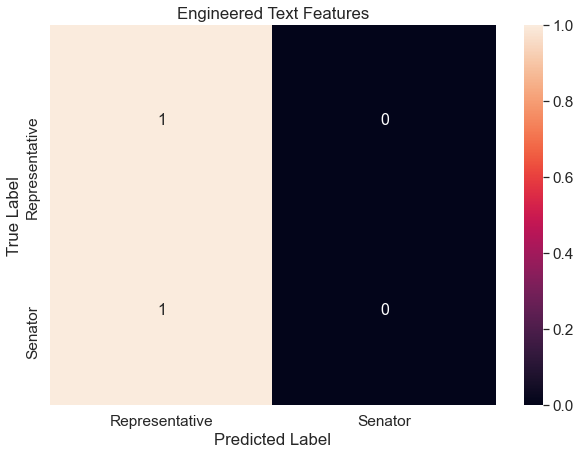

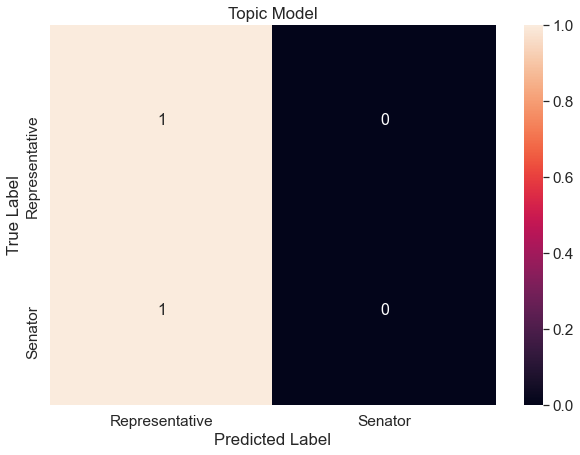

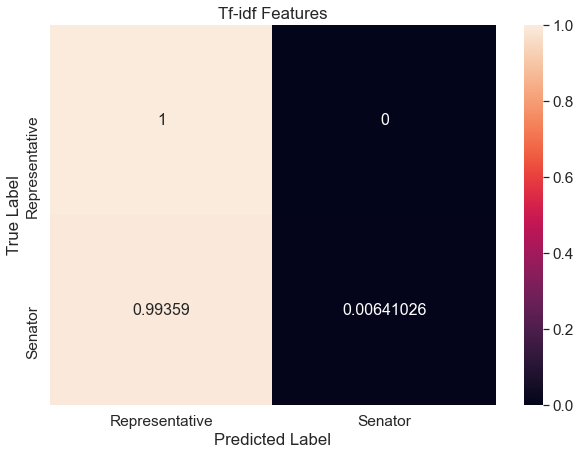

In [57]:
for dataframe, featurization in zip(dataframes, featurization_technique):
    X2_train, X2_test, y2_train, y2_test = train_test_split(dataframe, 
                                                        y2, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X2_train, y2_train.ravel())

    y2_pred = logit_model.predict(X2_test)
    
    cf_matrix = confusion_matrix(y2_test, y2_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Representative", 1: "Senator"})
    df_cm.index = ["Representative", "Senator"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

<b>What do we see?</b>
The three matrices show that the models overly predicted representatives than it did senators. The first two matrices show that all senators were predicted to be representative. 

### Two Combined Models

In [58]:
categories = ['position_binary', 'party_binary']
labels = [['Representative', 'Senator'], ['Democrat', 'Republican']]

In [59]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
ct_sub.columns
non_text_features = ct_sub[['trump_2016_state_share', 'clinton_2016_state_share', 
                        'obama_2012_state_share', 'romney_2012_state_share']]
non_text_features = non_text_features.replace({',':''}, regex=True)
non_text_features = non_text_features.apply(pd.to_numeric)
non_text_dummies = pd.get_dummies(ct_sub[['gender', 'state']]).reset_index(drop = True)
non_text_features = non_text_features.reset_index(drop = True).join(non_text_dummies)
non_text_features

,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,gender_F,gender_M,state_AK,state_AL,state_AR,state_AZ,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,1252401,1161167,1025232,1233654,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2819533,4556118,4485741,2490431,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2841005,2394164,2827709,2661437,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,409055,189765,212787,420911,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1202971,628854,679370,1087190,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2146015,3090729,3019512,2135216,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2996,2819533,4556118,4485741,2490431,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2997,2819533,4556118,4485741,2490431,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2998,2089104,1877963,1773827,2078688,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


position_binary


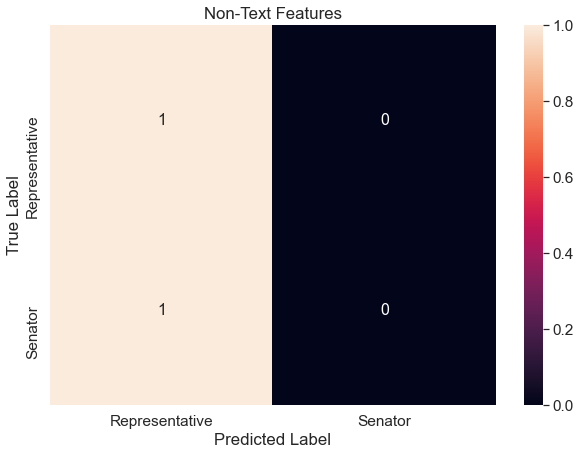

party_binary


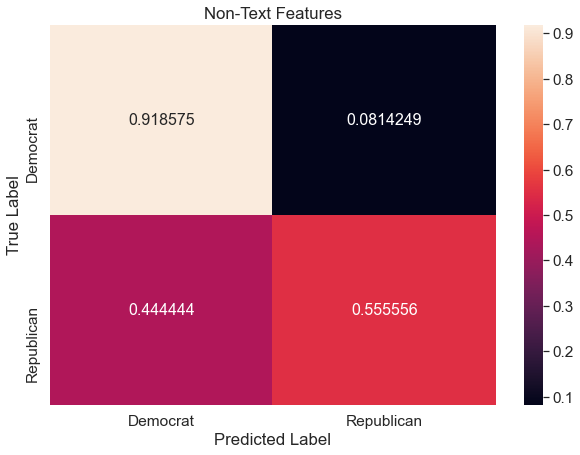

In [60]:
# Non-text model
dataframe = non_text_features
featurization = "Non-Text Features"
for category, label in zip(categories, labels):
    print(category)
    
    y = ct_sub[category]
    
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: label[0], 1: label[1]})
    df_cm.index = [label[0], label[1]]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
                annot=True,
                annot_kws={"size": 16},
                fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

<b>What do we see?</b>
When predicting positions, the model predicts “Representative” every time. When predicting party, the model overly predicts “Democrat”, however it is not only predicting “democrat” like the previous model with “representative”

position_binary


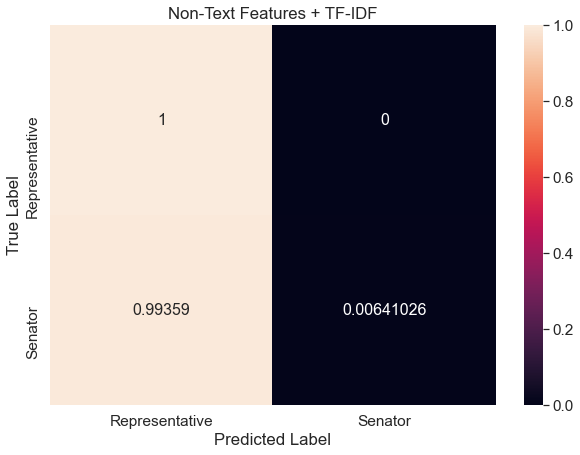

party_binary


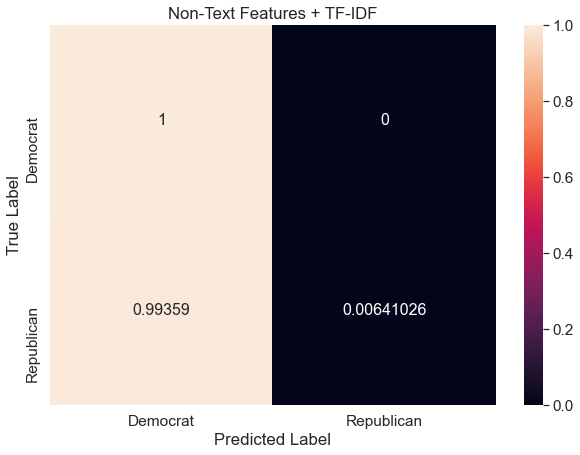

In [61]:
# Non-text plus text features from TF-IDF model
dataframe = tfidf_df.reset_index(drop = True).join(non_text_features)
featurization = "Non-Text Features + TF-IDF"
for category, label in zip(categories, labels):
    print(category)
    
    y = ct_sub[category]
    
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)

    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X2_train, y2_train.ravel())

    y2_pred = logit_model.predict(X2_test)
    
    cf_matrix = confusion_matrix(y2_test, y2_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: label[0], 1: label[1]})
    df_cm.index = [label[0], label[1]]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
                annot=True,
                annot_kws={"size": 16},
                fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

<b>What do we see?</b>
Similar to the Non-text model, this model almost always predicts “representative”. We see the same thing when predicting party. The model almost always predicts “democrat”.

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

Depending on the nature and context of the task, the preprocessing methods can be different. For example, in some cases we might want to keep the stopwords and the punctuation if we’re dealing with smaller corpi where certain punctuation marks and stop words are meaningful (e.g., email subject lines).  If we’re dealing with larger corpi, though, removing stop words and punctuation would significantly reduce noise and improve the performance of certain tasks such as classification. For example, removing stop words and punctuation from a corpus containing twitter data would improve a classification task because stop words and punctuation in this context do not contain useful information to help with prediction.

As such, preprocessing should be customized based on the size of the corpus and the task you are trying to perform. For example, if  the goal is to do sentiment analysis, we may not want to remove certain characters, emojis as they may signify some information about sentiment. There may be some words (e.g. RT) that may be used often but give no meaning or context for our NLP, and thus we might choose to remove it. 

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

We did not find any differences in sentiments among Congresspersons in comparing party affiliation (Democrat vs Republican) or Congressional membership (Senator vs Representative).

Patterns were generally the same, but we did pick up on something from our sentiment analysis.  As tweets got more subjective, there seemed to be some differences between Democrat vs. Republic.  We saw that for Democrats, more subjective meant more negative, whereas for Republicans, it was more positive.  This was not necessarily what we expected, but during discussions and upon reflection, we thought this might be likely a phenomena of Trump.  Because of the many tweets Trump was putting out there, there was likely increased number of counter tweets from Democrats, and their strong opposition might likely be why we see more negative sentiment from their party than from Republicans. 

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

You can validate against output values and patterns you expect to see based on prior knowledge you have. 

Sometimes, you might also only have access to output for some data and not others and would need to use unsupervised modeling for predicting output you don’t have.  If you can validate with supervised models to see if it predicts well, you might feel more confident in using the unsupervised model in similar contexts/to answer similar questions for predictions where you don't have output observations.

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

We cannot determine (or definitively conclude) which model performed the best since all of the models overly predicted Democrat and Representative as shown in the confusion matrices. Our exploratory data analysis shows that the overall number of tweets from Democrats is much greater than the number of tweets from Republicans. It might be the case that the model is overly predicting Democrats in relation to Republicans because the data contains a greater volume of tweets from Democrats. The fact that the majority of the representatives from the 116th US Congress are Democrats could also explain why the model overly predicted Representatives.

Combining text and non-text features likely improves the performance of our algorithm, since tweets include more than just text tweets (e.g. images, numerical text). This might be more likely in political tweets, so capturing more of the data will help in ultimately improving the performance of our predictions